# Binary classification on a cats vs. dogs dataset

* Based on:
 - tensorflow's transfer learning and early stopping guides https://www.tensorflow.org/guide/keras/transfer_learning
 https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
 - keras + kerastuner best practices notebook https://www.kaggle.com/kliuiev/keras-kerastuner-best-practices/edit
 - tensorflow's blog and github resources on keras tuner
https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
https://keras-team.github.io/keras-tuner/


* 50% of the dataset used
* Keras tuner to find optimal hyperparameters
* Data augmentation (using keras tuner)
* Transfer learning (VGG16 network)
* Fine-tuning (no keras tuner yet)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow import data

Install keras tuner

In [3]:
!pip install git+https://github.com/keras-team/keras-tuner.git -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Directory structure

Make sure you have the following directory structure under /kaggle/input/:

* .../train_validate (a directory with images for training and validation)
    * .../cats (a sub-directory with 12500 cats images)
    * .../dogs (a sub-directory with 12500 dogs images)
* .../test_dir/test (a directory with 12500 unlabelled images for testing)

**It is important the test_dir fodler contains a single "unlabelled" folder with all the test images in it. This is because ```image_dataset_from_directory``` expects at least a single directory under the specified path.**


To obtain the directory structure as above, you can use the output of my notebook "cats-vs-dogs-train-val-test-data"

# Set image and model parameters

Set a few parameters used in the model:

* image_size to resize the images after they are read from disk, all images must have the same size
* the recommended size of the images for the currently used network is   ...  pixels. 
* batch_size to set the batch size
* validation_share = 0.2 and training_share = 0.8 to use 20% of the original train-validate data for training and 80% for validation, for example, any other numbers like 0.1 and 0.4 are possible
* set base learning rate


In [4]:
# set image size and batch size
IMAGE_SIZE = (150,150)
BATCH_SIZE = 16

# set the size of the training and validation datasets
VALIDATION_SHARE = 0.1
TRAINING_SHARE = 0.4

# use a fixed number of epochs for fine tuning
FINE_TUNE_EPOCHS = 10




<span style="color:blue"> 
**In tensorflow documentation, they take only 40% of images for training (it is also said that transfer learning performs better for smaller data sets) and 10% for validation and use data augmentation (horizontal flip).**
<span>
    
<span style="color:blue">     
**Why are we using the data augmentation then?  Why did not we use let's say 80% train-validate data (0.8* 25000 images) for training and 20% for validation (0.2* 25000 images) instead?** 
<span>

# Load images


In ```image_dataset_from_directory```, set

* ```validation_split = validation_share```  for validation dataset and ```validation_split = 1 - training_share``` for training dataset 
* the directory where the data are located
* ```labels = "inferred"``` to generate labels from the directory structure
* ```label_mode = 'binary'``` to encode the labels as scalars with values 0 and 1
* the explicit class names (which must match the names of the directories) to control the order of classes: ```class_names = ["cats", "dogs"]```
* ```color_mode = "rgb"```
* the batch size is ```batch_size``` for training and validation
* the batch size for testing is ```batch_size_testing```
* the size to resize the images after they read from disk, all images must have the same size
* ```shuffle = True``` for training and validation to shuffle the data and provide the ```seed``` argument to make sure there is no overlap between the training and validation datasets
* ```shuffle = False``` for testing data because we want to keep the datasets and their labels (filenames) ordered
* ```subset = "training"``` for training dataset and ```subset = "validation"``` for validation dataset
* ```label_mode = "binary"```  for training and validation
* ```label_mode = None``` for testing

In [5]:
train_validate_directory = '/kaggle/input/fork-of-cats-vs-dogs-train-val-test-data/train_validate/'

training_ds = keras.preprocessing.image_dataset_from_directory(
    train_validate_directory, 
    labels='inferred', 
    label_mode='binary', 
    class_names = ["cats","dogs"], 
    color_mode='rgb',
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True,
    seed=1,
    validation_split = 1 - TRAINING_SHARE,
    subset="training",
)

Found 25000 files belonging to 2 classes.
Using 10000 files for training.


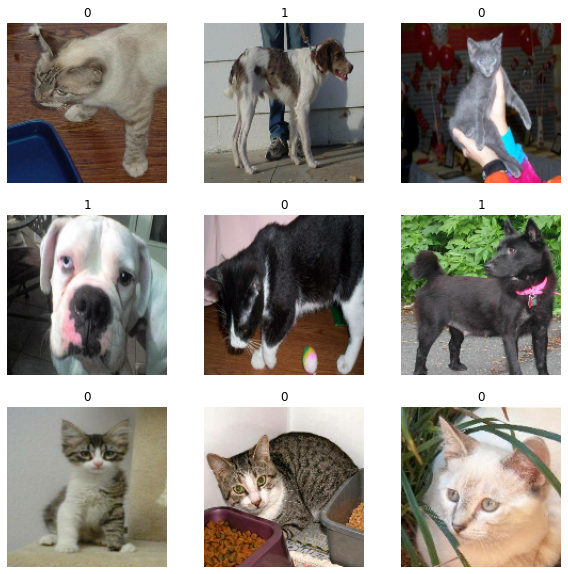

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
train_validate_directory = '/kaggle/input/fork-of-cats-vs-dogs-train-val-test-data/train_validate/'

validation_ds = keras.preprocessing.image_dataset_from_directory(
    train_validate_directory, 
    labels='inferred', 
    label_mode='binary', 
    class_names = ["cats","dogs"], 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed = 1,
    validation_split = VALIDATION_SHARE,
    subset="validation"
)

Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


In [8]:
#plt.figure(figsize=(10, 10))
#for images, labels in validation_ds.take(1):
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#        plt.axis("off")

**To return test images *along with their corresponding paths*, I use an overriden IMAGE_DATASET_FROM_DIRECTORY function from here** https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/keras/preprocessing/image_dataset.py#L34-L206

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

WHITELIST_FORMATS = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

## Tensorflow override method to return fname as list as well as dataset

def my_image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=BATCH_SIZE,
                                 image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                 shuffle=True,
                                 seed=None,
                                 validation_split=None,
                                 subset=None,
                                 interpolation='bilinear',
                                 follow_links=False):
  
  if labels != 'inferred':
    if not isinstance(labels, (list, tuple)):
      raise ValueError(
          '`labels` argument should be a list/tuple of integer labels, of '
          'the same size as the number of image files in the target '
          'directory. If you wish to infer the labels from the subdirectory '
          'names in the target directory, pass `labels="inferred"`. '
          'If you wish to get a dataset that only contains images '
          '(no labels), pass `label_mode=None`.')
    if class_names:
      raise ValueError('You can only pass `class_names` if the labels are '
                       'inferred from the subdirectory names in the target '
                       'directory (`labels="inferred"`).')
  if label_mode not in {'int', 'categorical', 'binary', None}:
    raise ValueError(
        '`label_mode` argument must be one of "int", "categorical", "binary", '
        'or None. Received: %s' % (label_mode,))
  if color_mode == 'rgb':
    num_channels = 3
  elif color_mode == 'rgba':
    num_channels = 4
  elif color_mode == 'grayscale':
    num_channels = 1
  else:
    raise ValueError(
        '`color_mode` must be one of {"rbg", "rgba", "grayscale"}. '
        'Received: %s' % (color_mode,))
  interpolation = image_preprocessing.get_interpolation(interpolation)
  dataset_utils.check_validation_split_arg(
      validation_split, subset, shuffle, seed)

  if seed is None:
    seed = np.random.randint(1e6)
  image_paths, labels, class_names = dataset_utils.index_directory(
      directory,
      labels,
      formats=WHITELIST_FORMATS,
      class_names=class_names,
      shuffle=shuffle,
      seed=seed,
      follow_links=follow_links)

  if label_mode == 'binary' and len(class_names) != 2:
    raise ValueError(
        'When passing `label_mode="binary", there must exactly 2 classes. '
        'Found the following classes: %s' % (class_names,))

  image_paths, labels = dataset_utils.get_training_or_validation_split(
      image_paths, labels, validation_split, subset)

  dataset = paths_and_labels_to_dataset(
      image_paths=image_paths,
      image_size=image_size,
      num_channels=num_channels,
      labels=labels,
      label_mode=label_mode,
      num_classes=len(class_names),
      interpolation=interpolation)
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=BATCH_SIZE * 8, seed=seed)
  dataset = dataset.batch(BATCH_SIZE)
  # Users may need to reference `class_names`.
  dataset.class_names = class_names
  return dataset, image_paths

def paths_and_labels_to_dataset(image_paths,
                                image_size,
                                num_channels,
                                labels,
                                label_mode,
                                num_classes,
                                interpolation):
  """Constructs a dataset of images and labels."""
  # TODO(fchollet): consider making num_parallel_calls settable
  path_ds = dataset_ops.Dataset.from_tensor_slices(image_paths)
  img_ds = path_ds.map(
      lambda x: path_to_image(x, image_size, num_channels, interpolation))
  if label_mode:
    label_ds = dataset_utils.labels_to_dataset(labels, label_mode, num_classes)
    img_ds = dataset_ops.Dataset.zip((img_ds, label_ds))
  return img_ds


def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

Use the complete set of the original test data (12500 images) for testing.

* set ```image_size=IMAGE_SIZE```,```label_mode=None``` and ```batch_size=12500```

In [10]:
testing_directory = '/kaggle/input/fork-of-cats-vs-dogs-train-val-test-data/test_dir/'

#testing_ds = keras.preprocessing.image_dataset_from_directory(
testing_ds, testing_paths = my_image_dataset_from_directory(
    testing_directory, 
    label_mode=None, 
    color_mode='rgb', 
    batch_size=12500,
    image_size=IMAGE_SIZE, 
    shuffle=False,
    seed = 1
)

Found 12500 files belonging to 1 classes.


Print the number of batches

In [11]:
print("Number of training batches: %d" % data.experimental.cardinality(training_ds))
print("Number of validation batches: %d" % data.experimental.cardinality(validation_ds))
print("Number of test batches: %d" % data.experimental.cardinality(testing_ds))

Number of training batches: 625
Number of validation batches: 157
Number of test batches: 782


# **Cache and prefetch the data to optimize loading speed**

From the tensorflow documentation:

* Caching saves some operations (like file opening and data reading) from being executed during each epoch.

* Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

* Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

* The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime.

* Note: Like other Dataset methods, prefetch operates on the elements of the input dataset. It has no concept of examples vs. batches. examples.prefetch(2) will prefetch two elements (2 examples), while examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).

In [12]:
training_ds = training_ds.cache().prefetch(data.experimental.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(data.experimental.AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(data.experimental.AUTOTUNE)

# Data pre-processing

* Data pre-processing consists of data augmentation and data standardization (resizing and intensity normalization).

* To benefit from the GPU acceleration, make it part of the model. 

* From Tensorflow documentation: "When data preprocessing is part of the model, other people can load and use your model without having to be aware of how each feature is expected to be encoded and normalized. "


# Build a model

## Base model

* Use a pre-trained model as a base model
* Set weights to ```imagenet```
* Do not include the fully-connected layer at the top of the network
* Freeze the model

*From tensorflow documentation:*

*The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.*

In [13]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

## Full model

* The model is built using the Keras functional API. 

* From Keras documentation: "The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs. The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers."

* The first step is to create an input node

* This is followed by data augmentation (using a custom function called on the ```inputs``` object).

* Keras tuner is used to find optimal augmentation hyperparameters

* The images are resized as part of the model using 

```
tf.keras.layers.experimental.preprocessing.Resizing
```


* The pixel values are rescaled as part of the model too using

```
x = keras.applications.vgg16.preprocess_input(x)
```


* The base model is called on the processed data 

* **Make sure to pass ```training=False``` when calling the base model!**

```
x = base_model(x, training = False)
```

* This ensures the model runs in inference mode, so that batchnorm statistics is not updated even after we unfreeze the base model for fine tuning.  


* Add fully connected layers before the classification layer. 

* Keras tuner is used to find their optimal hyperparameters

* Use Adam optimizer and tune its learning rate with the Keras tuner

* Use ```keras.losses.BinaryCrossentropy()``` loss because there are only two classes and set ```from_logits=True``` as the model itself does not implement a sigmoid activation of the last layer.



In [14]:
from kerastuner import HyperModel

from tensorflow import keras
from tensorflow.keras import layers

def data_augmentation(x, hp):

    x = layers.experimental.preprocessing.RandomRotation(
        factor = hp.Float('random_rotation', min_value=0.05, max_value=0.2, step = 0.05)
    )(x)

    x = layers.experimental.preprocessing.RandomZoom(
        height_factor = hp.Float('random_zoom', min_value=0.05, max_value=0.2, step = 0.05)
    )(x)

    x = layers.experimental.preprocessing.RandomWidth(
        factor = hp.Float("random_width", min_value = 0.05, max_value = 0.2, step = 0.05)
    )(x)

    x = layers.experimental.preprocessing.RandomHeight(
        factor = hp.Float("random_height", min_value = 0.05, max_value = 0.2, step = 0.05)
    )(x)

    x = layers.experimental.preprocessing.RandomTranslation(
        height_factor = hp.Float("rand_trans_h", min_value = 0.05, max_value = 0.2, step = 0.05),
        width_factor = hp.Float("rand_trans_w", min_value = 0.05, max_value = 0.2, step = 0.05)
    )(x)

    x = layers.experimental.preprocessing.RandomFlip(
        mode = hp.Choice('random_flip', ['horizontal', 'vertical'])
    )(x)
    return x

def build_model(hp):
    
    # create an input mode
    inputs = keras.Input(shape=(150,150,3))

    # data augmentation
    x = data_augmentation(inputs, hp)
    
    # data standardization
    # omit rescaling as it will apparently be done as part of preprocessing
    x = layers.experimental.preprocessing.Resizing(150,150, interpolation='bilinear')(x)
    
    # preprocess  before parsing to the base model
    x = keras.applications.vgg16.preprocess_input(x)

    
    # feed the processed data into the frozen base model
    x = base_model(x, training=False)
    
    # add fully connected layers on top of the base model
    # add a Flatten or a GlobalAveragePooling layer
    reduction_type = hp.Choice('reduction_type', ['flatten', 'avg'])
    if reduction_type == 'flatten':
        x = layers.Flatten()(x)
    else:
        x = layers.GlobalAveragePooling2D()(x)
    #
    # add a Dense layer
    x = layers.Dense(
        units=hp.Int('num_dense_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    )(x)
    #
    # add a Dropout layer
    x = layers.Dropout(
        hp.Float('dense_dropout', min_value=0.0, max_value=0.9)
    )(x)
    #
    # add the final layer
    outputs = layers.Dense(1)(x)
    #
    # build the model
    model = keras.Model(inputs, outputs)
    #
    # let the learning rate vary
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)
    #
    # compile the model
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[keras.metrics.BinaryAccuracy()])
    #
    # print the summary
    model.summary()


    return model

# Run hyperparameter search

In [15]:
import kerastuner as kt


tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_binary_accuracy',
    max_trials=100,
    overwrite=True)

callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                         mode='max', 
                                         patience=3, 
                                         baseline=0.9)]

tuner.search(training_ds,
             validation_data=validation_ds,
             callbacks=callbacks, 
             verbose=1, 
             epochs=100)

Trial 100 Complete [00h 02m 57s]
val_binary_accuracy: 0.9631999731063843

Best val_binary_accuracy So Far: 0.975600004196167
Total elapsed time: 03h 46m 14s


In [16]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_binary_accuracy', direction='max')
Trial summary
Hyperparameters:
random_rotation: 0.05
random_zoom: 0.2
random_width: 0.15000000000000002
random_height: 0.1
rand_trans_h: 0.15000000000000002
rand_trans_w: 0.2
random_flip: horizontal
reduction_type: avg
num_dense_units: 448
dense_dropout: 0.21869985707427075
learning_rate: 0.0028592065987744285
Score: 0.975600004196167
Trial summary
Hyperparameters:
random_rotation: 0.1
random_zoom: 0.15000000000000002
random_width: 0.2
random_height: 0.15000000000000002
rand_trans_h: 0.1
rand_trans_w: 0.05
random_flip: horizontal
reduction_type: avg
num_dense_units: 320
dense_dropout: 0.375709026497382
learning_rate: 0.008955248258252148
Score: 0.9747999906539917
Trial summary
Hyperparameters:
random_rotation: 0.1
random_zoom: 0.15000000000000002
random_width: 0.2
random_height: 0.15000000000000002
rand_trans_h: 0.15000000000000002
rand_trans_w: 0.1
random_flip: h

# Find the best epoche value

In [17]:
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model(best_hp)

history = model.fit(training_ds, 
                    epochs = 50, 
                    validation_data=validation_ds,
                    verbose = 1)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_width_1 (RandomWidth) (None, 150, None, 3)      0         
_________________________________________________________________
random_height_1 (RandomHeigh (None, None, None, 3)     0         
_________________________________________________________________
random_translation_1 (Random (None, None, None, 3)     0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, None, None, 3)    

# Train the production model

In [18]:
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
model = build_model(best_hp)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_width_2 (RandomWidth) (None, 150, None, 3)      0         
_________________________________________________________________
random_height_2 (RandomHeigh (None, None, None, 3)     0         
_________________________________________________________________
random_translation_2 (Random (None, None, None, 3)     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, None, None, 3)    

In [19]:
best_epoch

42

In [20]:
model.fit(training_ds,
          validation_data=validation_ds,
          epochs=best_epoch,
          verbose = 1)

Epoch 1/42
625/625 [==============================] - 18s 29ms/step - loss: 0.3327 - binary_accuracy: 0.9118 - val_loss: 0.1679 - val_binary_accuracy: 0.9532
Epoch 2/42
625/625 [==============================] - 18s 29ms/step - loss: 0.1579 - binary_accuracy: 0.9345 - val_loss: 0.1197 - val_binary_accuracy: 0.9628
Epoch 3/42
625/625 [==============================] - 17s 28ms/step - loss: 0.1407 - binary_accuracy: 0.9445 - val_loss: 0.0957 - val_binary_accuracy: 0.9668
Epoch 4/42
625/625 [==============================] - 18s 29ms/step - loss: 0.1312 - binary_accuracy: 0.9459 - val_loss: 0.0955 - val_binary_accuracy: 0.9712
Epoch 5/42
625/625 [==============================] - 17s 28ms/step - loss: 0.1241 - binary_accuracy: 0.9489 - val_loss: 0.0816 - val_binary_accuracy: 0.9704
Epoch 6/42
625/625 [==============================] - 18s 29ms/step - loss: 0.1133 - binary_accuracy: 0.9542 - val_loss: 0.1146 - val_binary_accuracy: 0.9660
Epoch 7/42
625/625 [==============================] 

In [21]:
model.save('cats-vs-dogs-vgg16-tuner.h5')

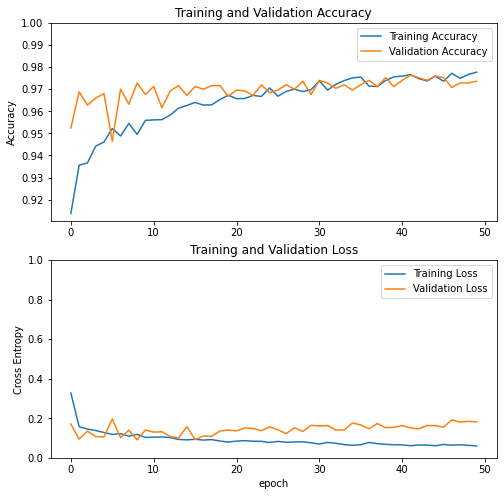

In [22]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Sometimes, the validation accuracy is higher than the training accuracy. In this case,

From TF documentation:

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

# Fine-tuning

In [23]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

* All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [25]:

# Fine-tune from this layer onwards - 16,17,18 (the first layer is 0)
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

* Recompile the model
* From TF documentation: As you are training a much larger model (on a data set that is rather small) and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [26]:
best_hp["learning_rate"]

0.0028592065987744285

In [27]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_width_2 (RandomWidth) (None, 150, None, 3)      0         
_________________________________________________________________
random_height_2 (RandomHeigh (None, None, None, 3)     0         
_________________________________________________________________
random_translation_2 (Random (None, None, None, 3)     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, None, None, 3)    

In [28]:
model.compile(
    optimizer = keras.optimizers.Adam(lr=best_hp["learning_rate"]/10),
    loss=keras.losses.BinaryCrossentropy(from_logits = True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [29]:
fine_tune_epochs = FINE_TUNE_EPOCHS

total_epochs =  best_epoch + fine_tune_epochs

history_fine = model.fit(training_ds,
                         epochs=total_epochs,
                         initial_epoch=best_epoch,
                         validation_data=validation_ds)

Epoch 43/52
625/625 [==============================] - 19s 31ms/step - loss: 0.2521 - binary_accuracy: 0.9112 - val_loss: 0.1057 - val_binary_accuracy: 0.9672
Epoch 44/52
625/625 [==============================] - 19s 31ms/step - loss: 0.1486 - binary_accuracy: 0.9368 - val_loss: 0.1339 - val_binary_accuracy: 0.9600
Epoch 45/52
625/625 [==============================] - 19s 31ms/step - loss: 0.1227 - binary_accuracy: 0.9493 - val_loss: 0.2177 - val_binary_accuracy: 0.9588
Epoch 46/52
625/625 [==============================] - 20s 32ms/step - loss: 0.1154 - binary_accuracy: 0.9467 - val_loss: 0.2560 - val_binary_accuracy: 0.9384
Epoch 47/52
625/625 [==============================] - 19s 31ms/step - loss: 0.0963 - binary_accuracy: 0.9604 - val_loss: 0.4541 - val_binary_accuracy: 0.9260
Epoch 48/52
625/625 [==============================] - 19s 31ms/step - loss: 0.0945 - binary_accuracy: 0.9600 - val_loss: 0.1565 - val_binary_accuracy: 0.9632
Epoch 49/52
625/625 [=========================

In [30]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

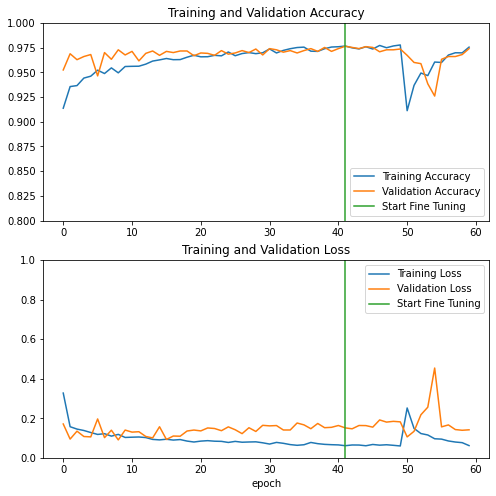

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([best_epoch-1,best_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([best_epoch-1,best_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

* 97.5% validation accuracy after learning from the frozen base model (rough search for optimal hp using keras tuner)
* ca. 1.5% improvement over the same model with manually set hyperparameters
* Slight to no improvement after fine-tuning (no keras tuner)

# Make predictions

In [32]:
predictions = model.predict(testing_ds, verbose=1, steps = 12500)

  782/12500 [>.............................] - 86s 110ms/step


In [33]:
predicted_label = []
predicted_label = [int(round(probability[0])) for probability in predictions]

In [34]:
import numpy as np
id = []
for testing_path in testing_paths:
    id.append(testing_path.split('.')[0].split('/')[-1])

In [35]:
import pandas as pd
submission_df = pd.DataFrame({'id':id, 'label':predicted_label})
submission_df = submission_df.sort_values(by=['id'])

In [36]:
submission_df.to_csv("submission.csv", index=False)

In [37]:
model.save('cats-vs-dogs-vgg16-keras-tuner-rough.h5')

In [38]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv